In [1]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_custom_weighted_graph(node_list, edge_weight_list, edge_route = []):
    """
    Draw a custom weighted graph with two different styles for edges based on their weights.
    
    Parameters:
    node_list (list): A list of nodes in the graph.
    edge_weight_list (list of tuples): A list of edges with weights, where each edge is represented as (node1, node2, weight).
    """

    # Create the graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(node_list)

    # Add edges with weights
    for (u, v, w) in edge_weight_list:
        if ((u,v) in edge_route) or ((v,u) in edge_route):
            G.add_edge(u, v, chosen = 1, weight=w)
        else:
            G.add_edge(u, v, chosen = 0, weight=w)

    # Separate the edges into large and small weight groups
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["chosen"] == 1]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["chosen"] == 0]

    # Get positions for all nodes - using a fixed seed for reproducibility
    pos = nx.circular_layout(G, scale=1)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000)

    # Draw the edges with weights > 0.5
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

    # Draw the edges with weights <= 0.5 in blue, dashed style
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

    # Draw edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

    # Set margins and display options
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()



In [2]:
from itertools import permutations
import random

def generate_network(num_nodes, rand_a, rand_b):
    nodes_list = [x for x in range(num_nodes)]
    edges = list(permutations(nodes_list, 2))
    edges_w = [(*x, random.randint(rand_a,rand_b)) for x in edges]

    return nodes_list, edges_w



In [3]:
import random
from itertools import permutations
import random


class NormalTSPGA:
    def __init__(self, nodes_list, edges_w_list, population_number,*, crossover_thd = None, mutation_thd = 0.1, exploration_terms = 1):
        self.nodes_list = nodes_list
        self.edges_w_list = edges_w_list
        self.population_number= population_number
        
        self.crossover_thd = crossover_thd
        self.mutation_thd = mutation_thd

        self.exploration_terms = exploration_terms
        
        # Easy way to store nodes weights
        self.nodes_weights = self.__generate_dict_cost()
        
        self.population = self.__get_random_dnas()
        self.step_number = 0
    def step(self):

        new_members = self.__crossover_and_mutation()
        self.population += new_members
        
        cost_list = list(map(lambda dna: self.__evaluate_cost_dna(dna),self.population))
        fitness_list = self.__get_fitness_values(cost_list)


        population_fitness = list(zip(self.population, fitness_list, cost_list))
        
        sorted_population = sorted(population_fitness, key=lambda x: x[1], reverse=True)
        
        most_probable_populations = [pop[0] for pop in sorted_population[:self.population_number]]
        
        mpp_cost_list = [pop[2] for pop in sorted_population[:self.population_number]]

        self.population = most_probable_populations


        self.step_number+=1
        
        return most_probable_populations, mpp_cost_list

    
    def __generate_dict_cost(self):
        
        nodes_weights = {node:{} for node in self.nodes_list}
        for edge in self.edges_w_list:
            nodes_weights[edge[0]][edge[1]] = edge[2]
            nodes_weights[edge[1]][edge[0]] = edge[2]

        import pandas as pd
        print("Edges paths")
        display(pd.DataFrame(nodes_weights).sort_index())
        return nodes_weights


    def __get_random_dnas(self):
        stacks=[]
        for x in range(self.population_number):
            dna = []
            for _ in range(len(self.nodes_list)):
                dna.append(random.choice(list(set(self.nodes_list)-set(dna))))
            stacks.append(dna)
        return stacks


    def generate_sequential_pairs(self, dna):
        if len(dna) < 2:
            return []
        
        return [(dna[i], dna[i+1]) for i in range(len(dna) - 1)]+[(dna[-1], dna[0])]
        
    def __evaluate_cost_dna(self, dna):
        paths = self.generate_sequential_pairs(dna)
        
        cost = sum(list(map(lambda pair: self.nodes_weights[pair[0]][pair[1]], paths)))
        del paths
        return cost

    def __get_fitness_values(self, cost_list):
        # Normalize costs to the range [0, 1]
        min_cost = min(cost_list)
        max_cost = max(cost_list)
        normalized_costs = [(cost - min_cost) / (max_cost - min_cost) for cost in cost_list]
        
        probabilities = [(1 - norm) for norm in normalized_costs]
        
        probabilities_sum = sum(probabilities)
        normalized_probabilities = [p / probabilities_sum for p in probabilities]

        exploration_idxs = random.choices(range(len(normalized_probabilities)), k=self.exploration_terms)

        # Forcing to preserve the element
        for idx in exploration_idxs:
            normalized_probabilities[idx] = 1
        
    
        return normalized_probabilities


    def __mutation(self, dna):
        """
            We evaluated the
            mutual exchange mutation in this survey, which
            randomly chooses two nodes and exchanges them.
        """
        a,b = random.sample(list(range(len(dna))), k=2)
        aux = dna[a]
        dna[a] = dna[b]
        dna[b] = aux
    
        return dna
        
    def __tradditional_crossover(self, dna_a, dna_b, crossover_thd = None):
        """
            crossover_thd is None then len(dna_a)//2
        """
        if crossover_thd is None:
            crossover_thd = len(dna_a)//2
        
        child_a = dna_a[:crossover_thd]
        child_b = dna_b[:crossover_thd]
    
        child_a = child_a+[node for node in dna_b if node not in child_a]
        child_b = child_b+[node for node in dna_a if node not in child_b]
    
        return child_a, child_b

    def __crossover_and_mutation(self):
        new_members = []
        mutation_thd = self.mutation_thd
        
        for dna_a, dna_b in list(permutations(self.population,2)):
            children_list = list(self.__tradditional_crossover(dna_a, dna_b))
            for idx, children in enumerate(children_list):
                # Verify mutation
                if random.uniform(0,1) <= mutation_thd:
                    children_list[idx] = self.__mutation(children)
                    
            new_members = new_members+children_list
        return new_members

In [8]:
nodes_list, edges_w = generate_network(num_nodes=5,rand_a=-200,rand_b=200)

ga = NormalTSPGA(nodes_list, edges_w, population_number=50,mutation_thd=0.7, exploration_terms=1)

Edges paths


,0,1,2,3,4
0,NaN,160.0,-9.0,124.0,63.0
1,160.0,NaN,-117.0,-108.0,-12.0
2,-9.0,-117.0,NaN,58.0,172.0
3,124.0,-108.0,58.0,NaN,-197.0
4,63.0,-12.0,172.0,-197.0,NaN


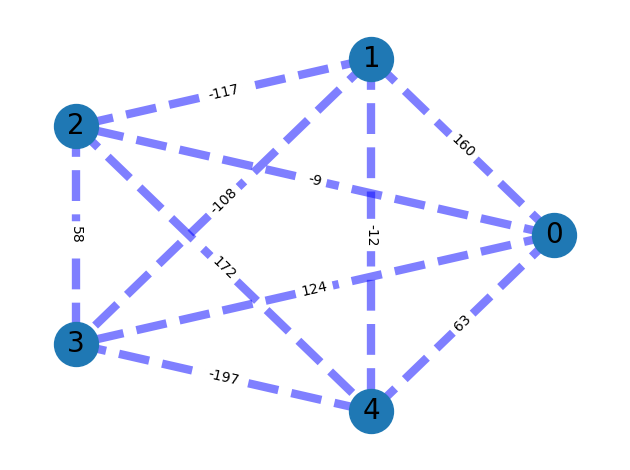

In [10]:
draw_custom_weighted_graph(nodes_list, edges_w,)

Step: 1 - Cost: -368


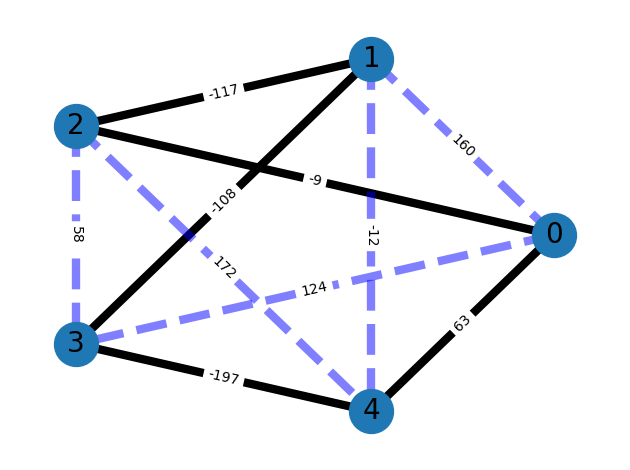

Step: 2 - Cost: -368


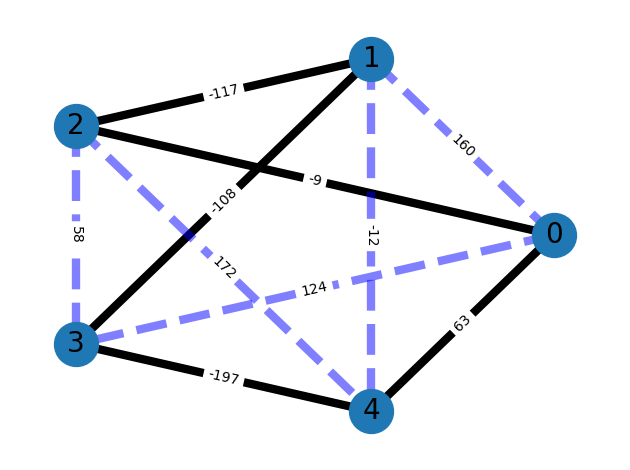

Step: 3 - Cost: -368


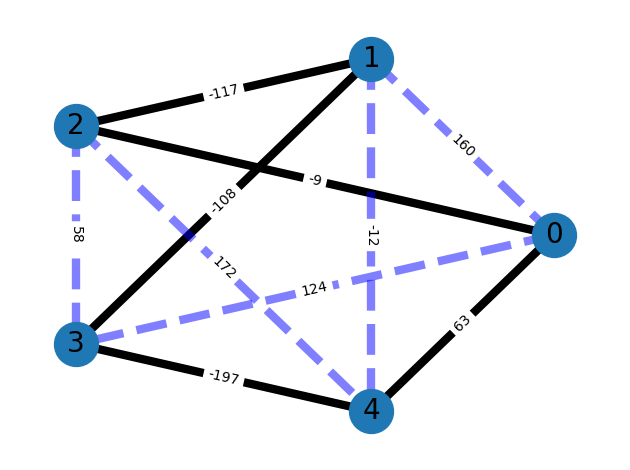

Step: 4 - Cost: -368


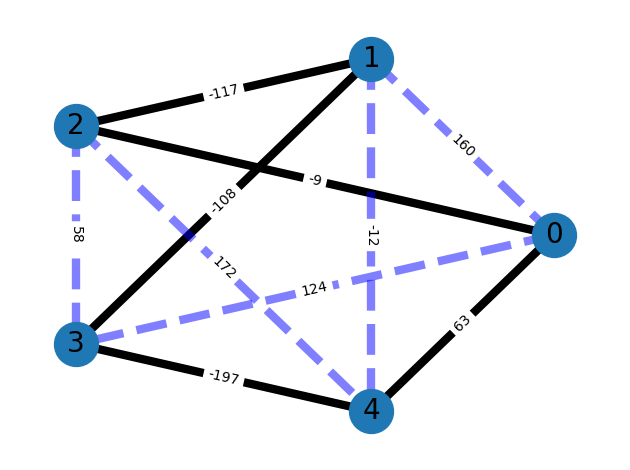

Step: 5 - Cost: -368


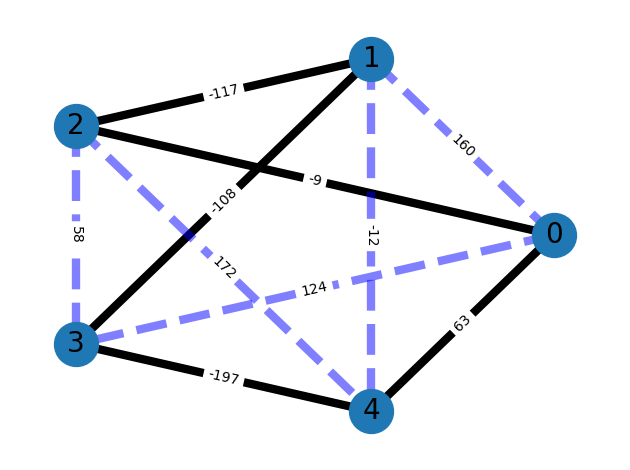

Step: 6 - Cost: -368


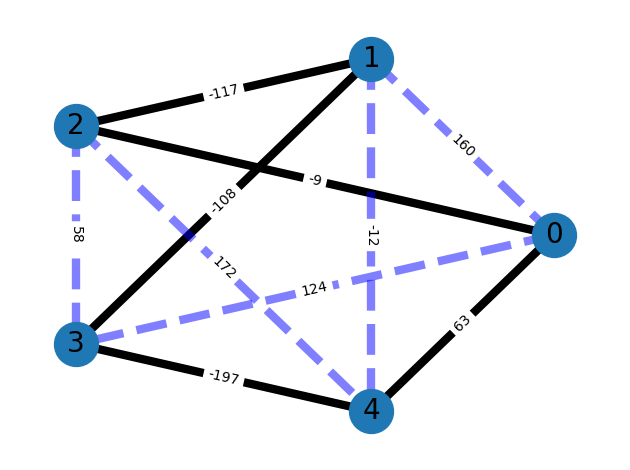

Step: 7 - Cost: -368


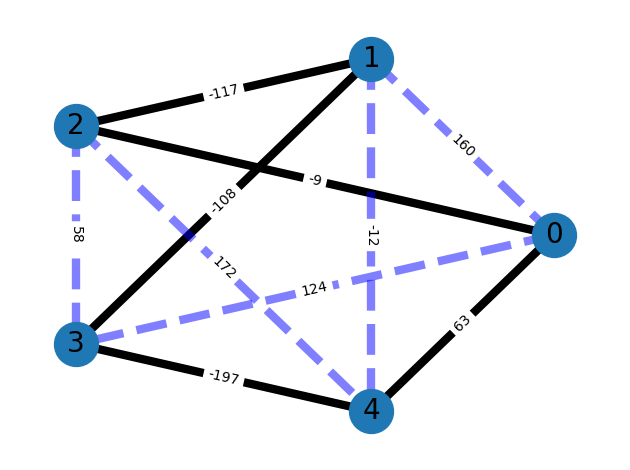

Step: 8 - Cost: -368


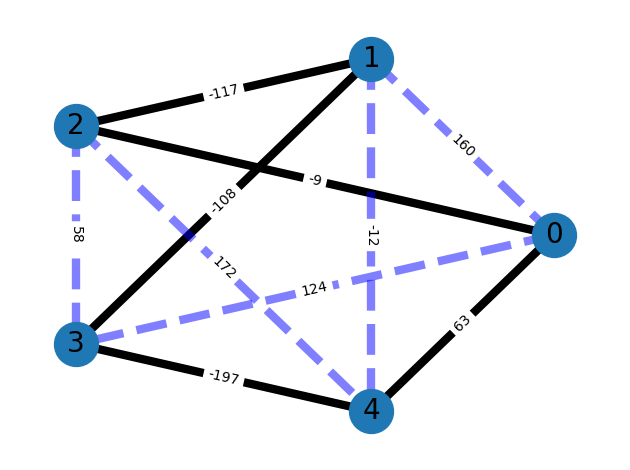

Step: 9 - Cost: -368


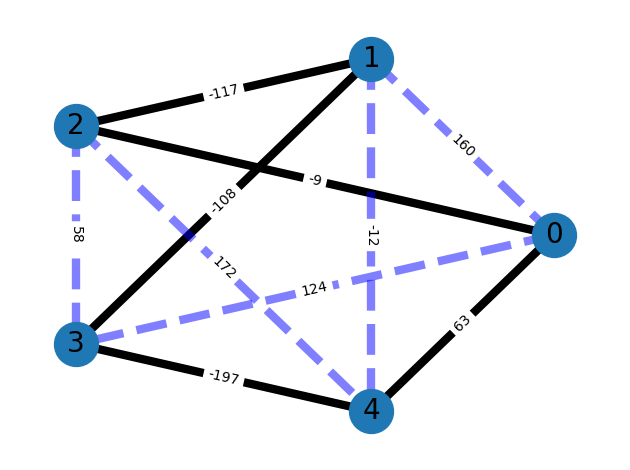

Step: 10 - Cost: -368


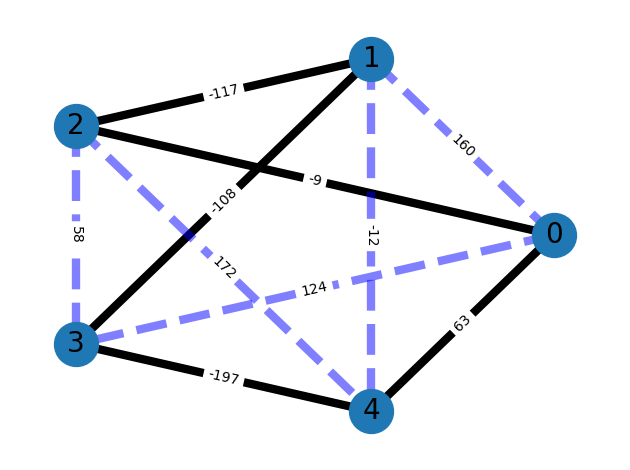

Step: 11 - Cost: -368


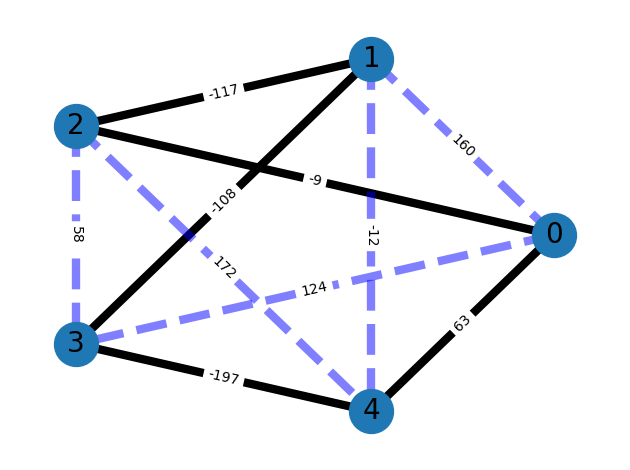

Step: 12 - Cost: -368


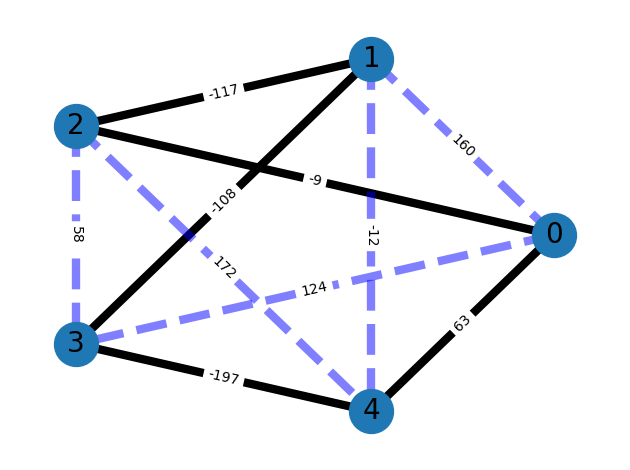

Step: 13 - Cost: -368


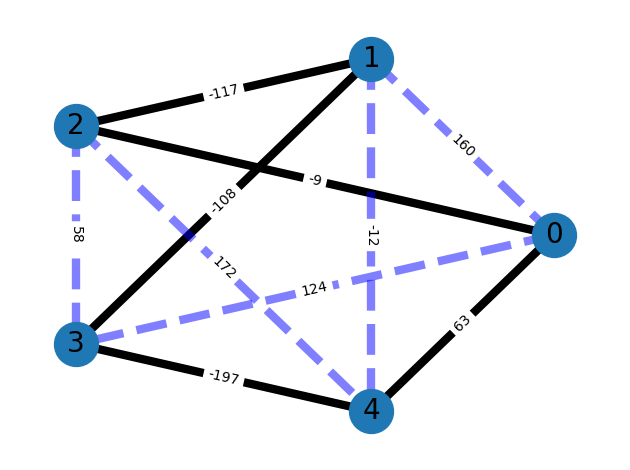

Step: 14 - Cost: -368


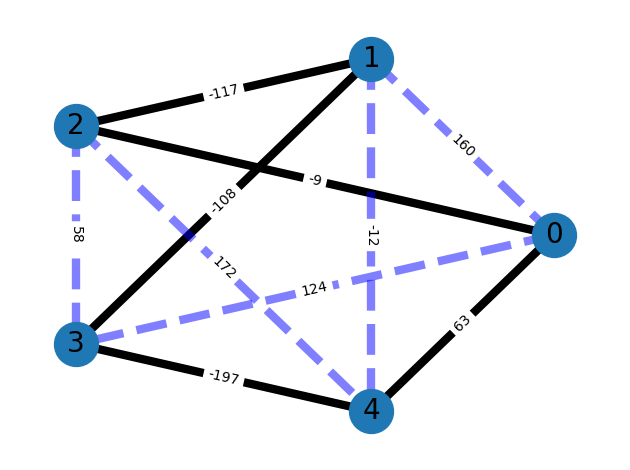

Step: 15 - Cost: -368


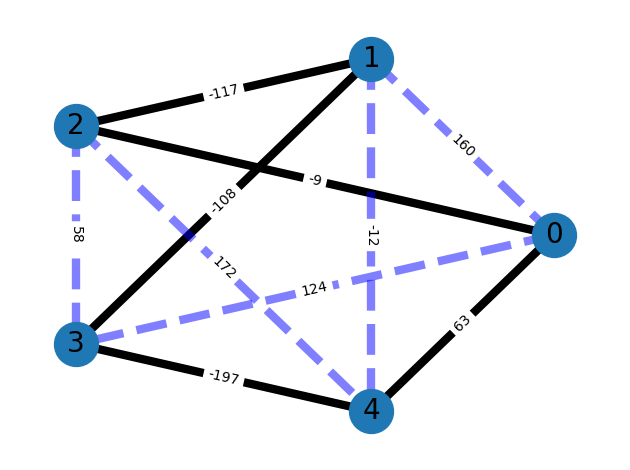

Step: 16 - Cost: -368


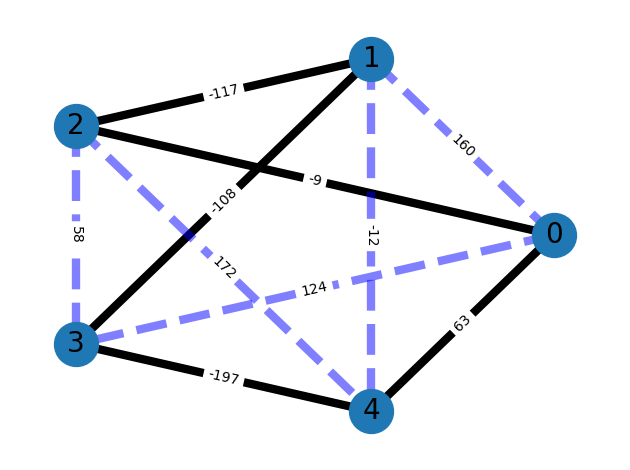

Step: 17 - Cost: -368


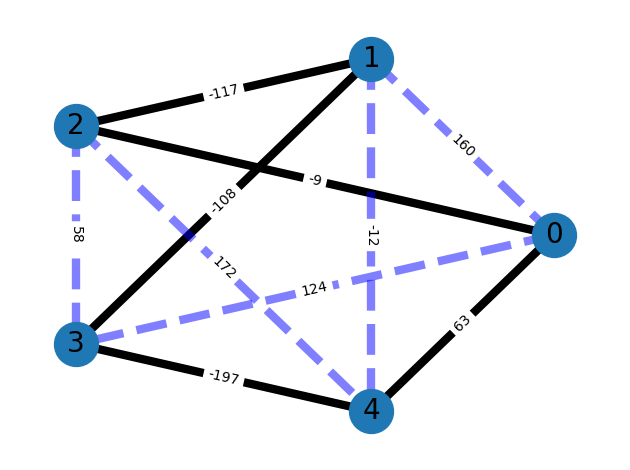

Step: 18 - Cost: -368


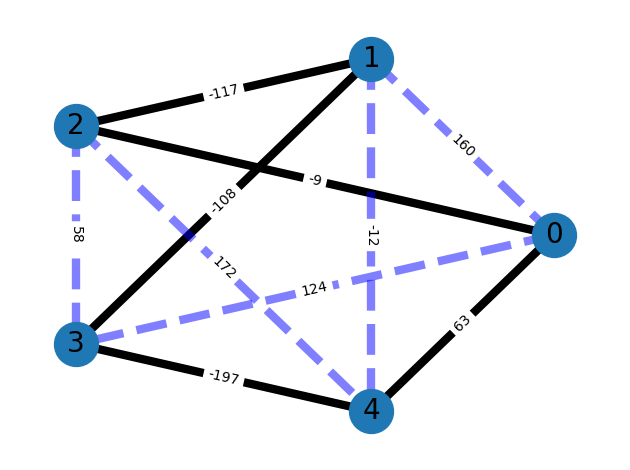

Step: 19 - Cost: -368


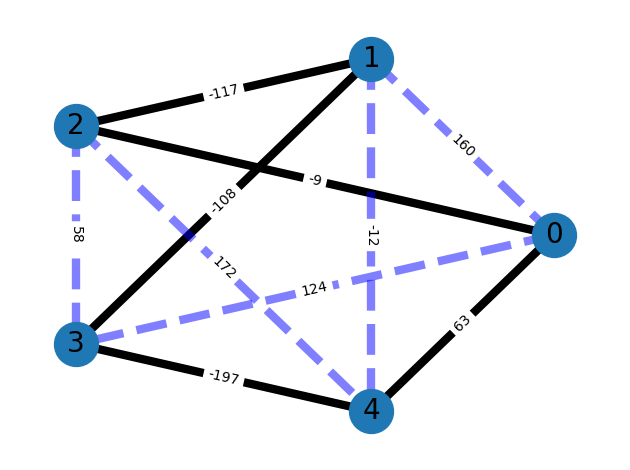

Step: 20 - Cost: -368


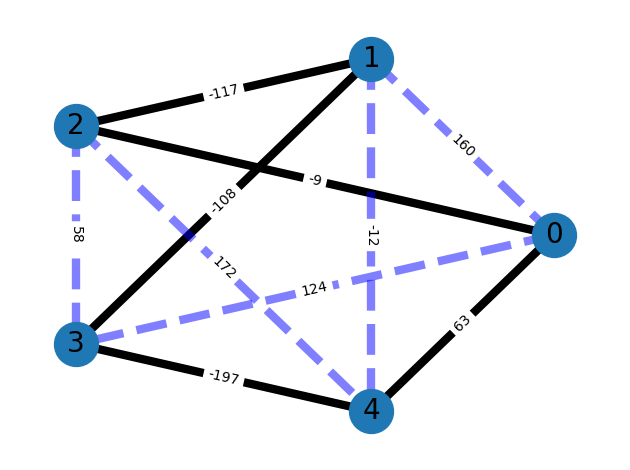

Step: 21 - Cost: -368


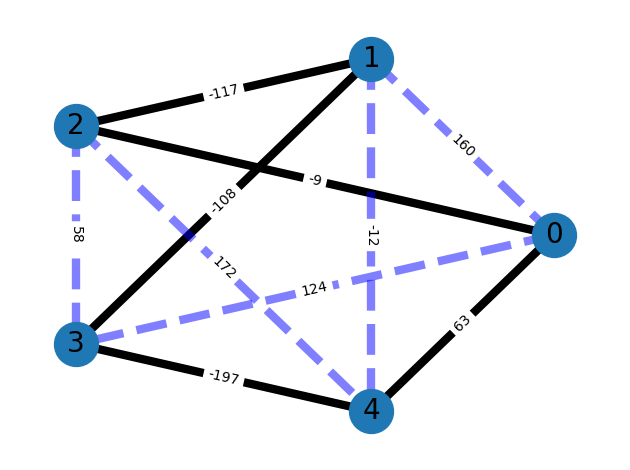

Step: 22 - Cost: -368


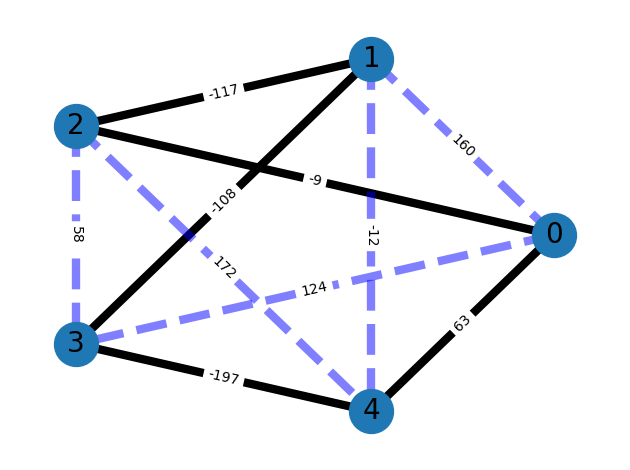

Step: 23 - Cost: -368


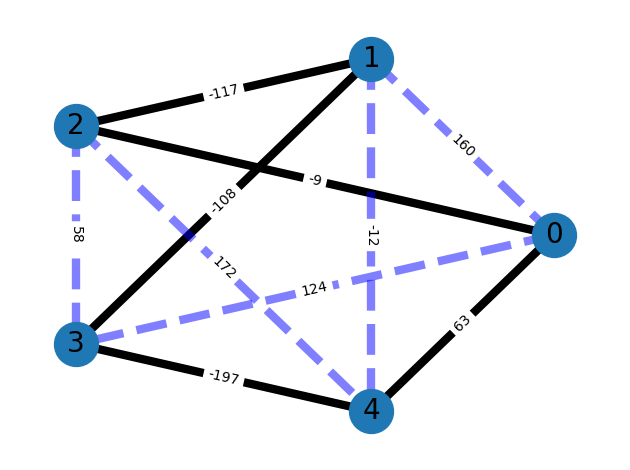

Step: 24 - Cost: -368


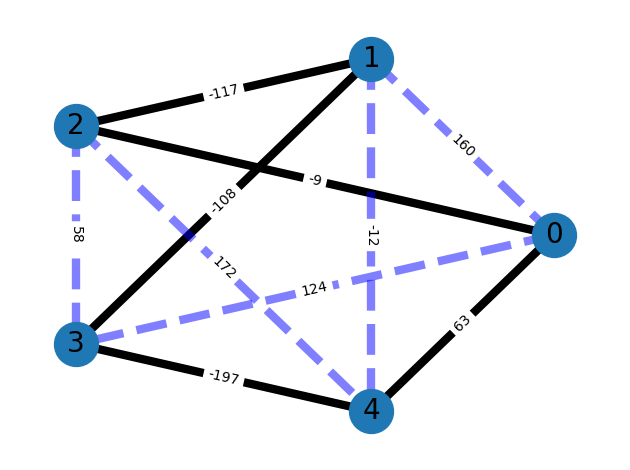

Step: 25 - Cost: -368


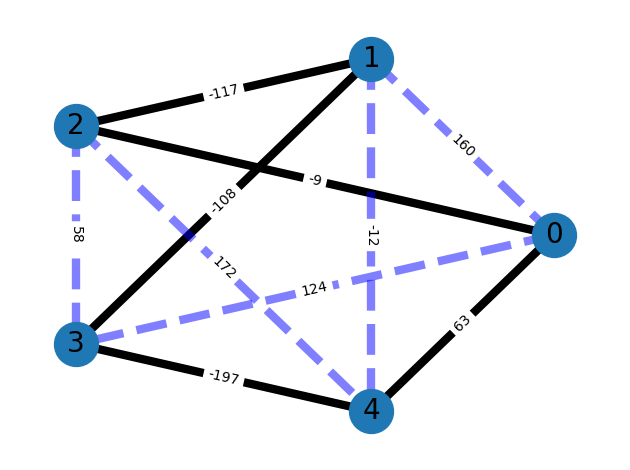

Step: 26 - Cost: -368


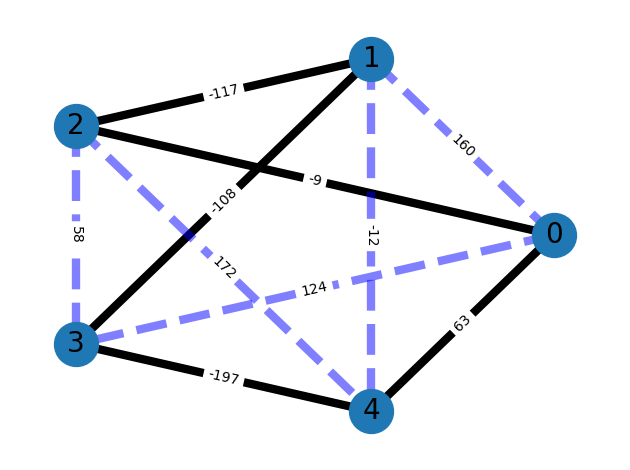

Step: 27 - Cost: -368


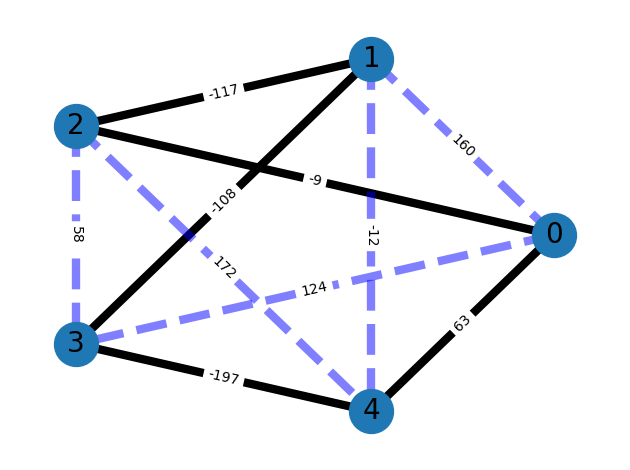

Step: 28 - Cost: -368


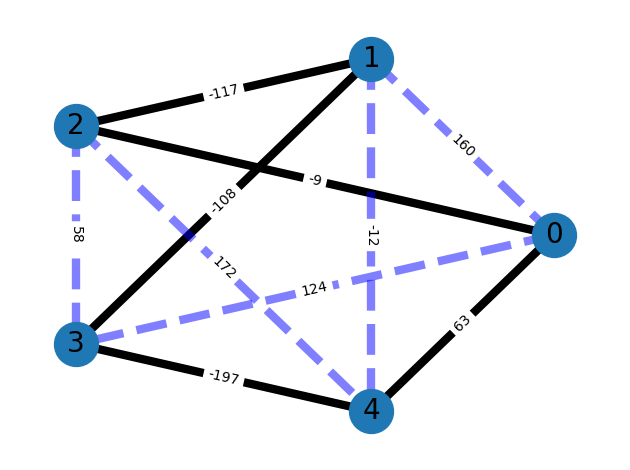

Step: 29 - Cost: -368


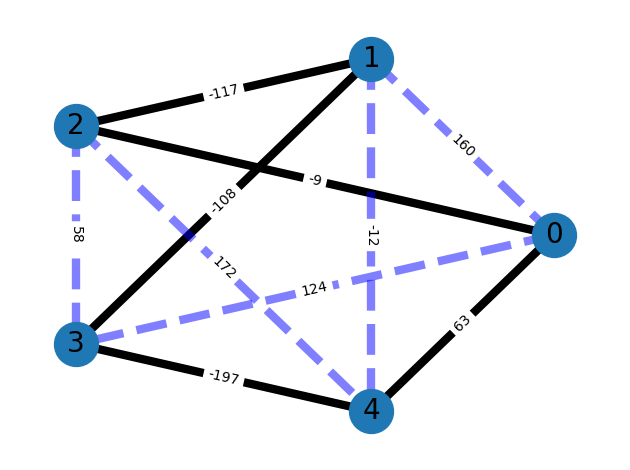

Step: 30 - Cost: -368


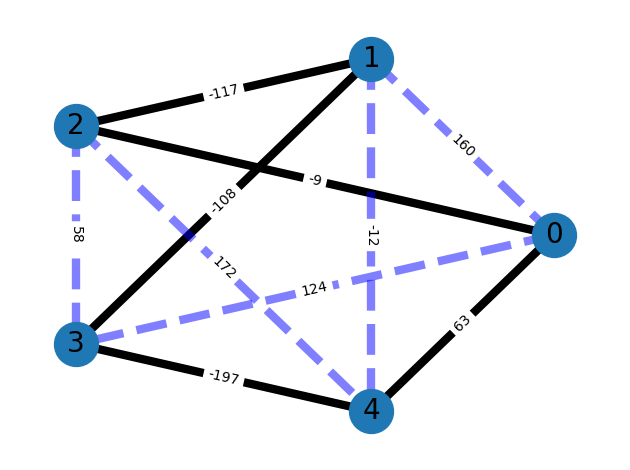

In [11]:
iterations = 30
for _ in range(iterations):
    new_population, new_costs = ga.step()
    tour,cost = min(zip(new_population, new_costs), key=lambda el:el[1])
    tour_edges = ga.generate_sequential_pairs(tour)
    print(f"Step: {ga.step_number} - Cost: {cost}")
    draw_custom_weighted_graph(nodes_list, edges_w, tour_edges)


In [7]:
ga.population

[[567,
  275,
  221,
  433,
  452,
  577,
  241,
  494,
  405,
  159,
  448,
  254,
  533,
  343,
  679,
  419,
  688,
  286,
  520,
  382,
  475,
  293,
  508,
  225,
  468,
  412,
  730,
  465,
  67,
  364,
  566,
  794,
  751,
  622,
  149,
  187,
  110,
  198,
  232,
  33,
  744,
  309,
  84,
  19,
  673,
  510,
  637,
  285,
  14,
  323,
  226,
  26,
  572,
  137,
  89,
  195,
  792,
  694,
  472,
  202,
  144,
  373,
  651,
  609,
  206,
  367,
  659,
  55,
  117,
  629,
  170,
  783,
  183,
  798,
  375,
  761,
  387,
  757,
  174,
  695,
  325,
  701,
  766,
  357,
  242,
  216,
  640,
  587,
  147,
  485,
  257,
  369,
  350,
  687,
  674,
  655,
  505,
  439,
  416,
  422,
  384,
  205,
  725,
  689,
  231,
  667,
  721,
  541,
  531,
  671,
  515,
  477,
  107,
  192,
  356,
  40,
  748,
  516,
  152,
  227,
  34,
  589,
  398,
  43,
  165,
  131,
  427,
  545,
  113,
  733,
  526,
  327,
  606,
  197,
  527,
  486,
  773,
  471,
  305,
  112,
  299,
  282,
  178,
  718,
  6